# Download data

In [3]:
large_mnist = "notMNIST_large"
small_mnist = "notMNIST_small"
import os

In [2]:
import tarfile
from urllib.request import urlretrieve

def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

In [3]:
download_file("https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz", large_mnist)
download_file("https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz", small_mnist)

# Load data

In [5]:
import imageio
import matplotlib.pyplot as plt
import random
import cv2

def load_data_from_pickle():
    return load_from_pickle("_train.pickle"), load_from_pickle("_val.pickle"), load_from_pickle("_test.pickle")

def load_from_pickle(pickle_name):
    with open(large_mnist + pickle_name, 'rb') as f:
        return pickle.load(f)

def load_data(folder):
    available_classes = os.listdir(folder)
    data = []
    for img_class in reversed(available_classes):
        print("Loading data from class '%s'" % img_class)
        images = os.listdir(folder + '/' + img_class)
        for image in images:
            path = folder + '/' + img_class + '/' + image
            try:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            except Exception as e:
                print(e)
                continue
            if img is None:
                continue
            data.append((img.flatten() / 255., available_classes.index(img_class)))
    return data, available_classes

data, available_classes = load_data(large_mnist)
print(len(data))

Loading data from class 'D'
Loading data from class 'A'
Loading data from class 'E'
Loading data from class 'C'
Loading data from class 'H'
Loading data from class 'J'
Loading data from class 'F'
Loading data from class 'I'
Loading data from class 'G'
Loading data from class 'B'
529114


## Plot data

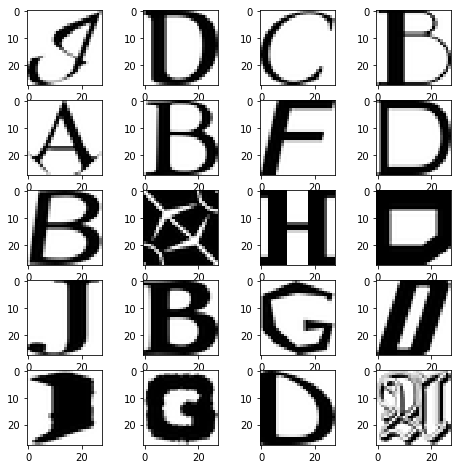

In [25]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(data)[0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.show()

## Check if balanced

In [22]:
from collections import Counter
import numpy as np

sizes = [d[1] for d in data]
class_counts = Counter(sizes)
print(class_counts)

balance_threshold = 0.1
is_balanced = True
mean_size = np.mean([s[1] for s in class_counts.items()])
for class_id, count in class_counts.items():
    if abs(count - mean_size) / mean_size > balance_threshold:
        print("Class %d is unbalanced" % class_id)
        is_balanced = False
if is_balanced:
    print("All classes are balanced")

Counter({8: 19842, 4: 19762, 7: 19697, 6: 19692, 0: 19666, 1: 19652, 9: 19607, 5: 19554, 3: 19455, 2: 17492})
Class 2 is unbalanced


## Train val test split

In [11]:
train_size = 200000
val_size = 10000
test_size = 19000

random.shuffle(data)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size: train_size + val_size + test_size]
print("Train data size: %d.\nVal data size: %d.\nTest data size: %d" 
      % (len(train_data), len(val_data), len(test_data)))

Train data size: 200000.
Val data size: 10000.
Test data size: 19000


## Remove duplicates

In [20]:
def remove_duplicates(train, val, test):
    index = {}
    for img, cls in val + test:
        if cls not in index:
            index[cls] = {}

        val_h = sum(img)
        if val_h not in index[cls]:
            index[cls][val_h] = []
        index[cls][val_h].append(img)
        
    duplicate_ids = []
    for i, img_cls in enumerate(train):
        img, cls = img_cls
        img = list(img)
        h = sum(img)
        if h in index[cls]:
            candidates = index[cls][h]
            for candidate in candidates:
                if list(candidate) == img:
                    duplicate_ids.append(i)
                    break
                
    print("%d duplicates is going to be removed from train dataset" % len(duplicate_ids))
    for data_id in reversed(duplicate_ids):
        del train[data_id]

In [21]:
remove_duplicates(train_data, val_data, test_data)

5581 duplicates is going to be removed from train dataset


## Dump data in order not to load it each time

In [26]:
import pickle

with open('notMNIST_large_train.pickle', 'wb') as f:
    pickle.dump(train_data, f)
with open('notMNIST_large_val.pickle', 'wb') as f:
    pickle.dump(val_data, f)
with open('notMNIST_large_test.pickle', 'wb') as f:
    pickle.dump(test_data, f)

# Train logistic regression model

In [28]:
import numpy as np

def unzip(tuples):
    first = [t[0] for t in tuples]
    second = [t[1] for t in tuples]
    return np.array(first), second

train_x, train_y = unzip(train_data)
val_x, val_y = unzip(val_data)
test_x, test_y = unzip(test_data)

In [33]:
# shift values
train_x -= 0.5
val_x -= 0.5
test_x -= 0.5

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

scores = []
c_values = [0.1, 0.5, 1, 1.2]
for c in c_values:
    clf = OneVsRestClassifier(LogisticRegression(C=c))
    clf.fit(train_x, train_y)
    score = clf.score(val_x, val_y)
    print("With c=%f score is %f" % (c, score))
    scores.append(score)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

With c=0.100000 score is 0.827400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

With c=0.500000 score is 0.825900


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

With c=1.000000 score is 0.826500


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

With c=1.200000 score is 0.825700


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


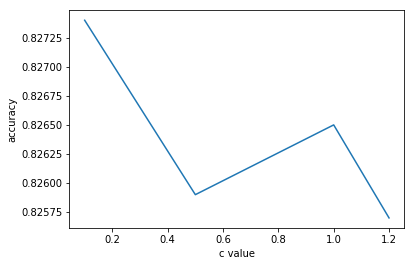

In [42]:
plt.plot(c_values, scores)
plt.ylabel('accuracy')
plt.xlabel('c value')
plt.show()

In [38]:
clf_test = OneVsRestClassifier(LogisticRegression(C=0.1))
clf_test.fit(train_x, train_y)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [43]:
clf_test.score(test_x, test_y)

0.8272631578947368

In [45]:
scores = []
train_sizes = [2000, 20000, 40000, 100000, 200000]
for train_size in train_sizes:
    sub_train_x = train_x[:train_size]
    sub_train_y = train_y[:train_size]

    clf = OneVsRestClassifier(LogisticRegression(C=0.1))
    clf.fit(sub_train_x, sub_train_y)
    score = clf.score(test_x, test_y)
    scores.append(score)
    print("Train size = %d, score = %f" % (train_size, score))

Train size = 2000, score = 0.801316


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

Train size = 20000, score = 0.817105


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

Train size = 40000, score = 0.820000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

Train size = 100000, score = 0.824684


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

Train size = 200000, score = 0.827263


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


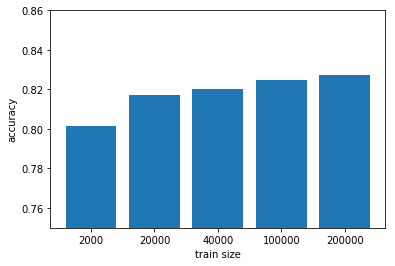

In [51]:
plt.bar([str(s) for s in train_sizes], scores)
plt.ylim((0.75, 0.86))
plt.ylabel('accuracy')
plt.xlabel('train size')
plt.show()